# Parcels Tutorial

Welcome to a quick tutorial on Parcels. This is meant to get you started with the code, and give you a flavour of some of the key features of Parcels.

In this tutorial, we will first cover how to run a set of particles [from a very simple idealised field](#Running-particles-in-an-idealised-field). We will show how easy it is to run particles in [time-backward mode](#Running-particles-in-backward-time). Then, we will show how to [add custom behaviour](#Adding-a-custom-behaviour-kernel) to the particles. Then we will show how to [run particles in a set of NetCDF files from external data](#Reading-in-data-from-arbritrary-NetCDF-files). Then we will show how to use particles to [sample a field](#Sampling-a-Field-with-Particles) such as temperature or sea surface height. And finally, we will show how to [write a kernel that tracks the distance travelled by the particles](#A-second-example-kernel:-calculating-distance-travelled).

Let's start with importing the relevant modules. The key ones are all in the `parcels` directory.

In [1]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

## Running particles in an idealised field

The first step to running particles with Parcels is to define a `FieldSet` object, which is simply a collection of hydrodynamic fields. In this first case, we use a simple flow of two idealised moving eddies. That field is saved in NetCDF format in the directory `examples/MovingEddies_data`. Since we know that the files are in what's called `NEMO` format, we can call these files using the function `FieldSet.from_nemo()`.

In [3]:
fieldset = FieldSet.from_nemo("parcels_examples/MovingEddies_data/moving_eddies")

The `fieldset` can then be visualised with the `show()` function. To plot an animation of the zonal velocity (`U`), give the following command

In [4]:
fieldset.U.show(animation=True)

The next step is to define a `ParticleSet`. In this case, we start 2 particles at (3.3E, 46N) and (3.3E, 47.8N) using the `from_list` constructor method, that are advected on the `fieldset` we defined above. Note that we use `JITParticle` as `pclass`, because we will be executing the advection in JIT (Just-In-Time) mode. The alternative is to run in `scipy` mode, in which case `pclass` is `ScipyParticle`

In [5]:
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=[ 3.3,  3.3],    # a vector of release longitudes 
                             lat=[46.0, 47.8])    # a vector of release latitudes

Print the `ParticleSet` to see where they start

In [6]:
print(pset)

P[0](lon=3.300000, lat=46.000000, depth=0.000000, time=not_yet_set)
P[1](lon=3.300000, lat=47.799999, depth=0.000000, time=not_yet_set)


This output shows for each particle the (longitude, latitude, depth, time). Note that in this case the time is `not_yet_set`, that is because we didn't specify a `time` when we defined the `pset`.

To plot the positions of these particles on the zonal velocity, use the following command

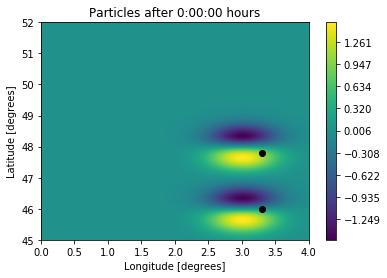

In [7]:
pset.show(field=fieldset.U)

The final step is to run (or 'execute') the `ParticelSet`. We run the particles using the `AdvectionRK4` kernel, which is a 4th order Runge-Kutte implementation that comes with Parcels. We run the particles for 6 days (using the `timedelta` function from `datetime`), at an RK4 timestep of 5 minutes. We store the trajectory information at an interval of 1 hour in a file called `EddyParticles.nc`. Because `time` was `not_yet_set`, the particles will be advected from the first date available in the `fieldset`, which is the default behaviour.

In [8]:
pset.execute(AdvectionRK4,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=6),    # the total length of the run
             dt=timedelta(minutes=5),      # the timestep of the kernel
             interval=timedelta(hours=1),  # the interval at which output is stored
             output_file=pset.ParticleFile(name="EddyParticles"))  # the name of the output file

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/bcc43ad3081f47f95b4771cb529b7217.so


The code should have run, which can be confirmed by printing and plotting the `ParticleSet` again

P[0](lon=2.024544, lat=46.088627, depth=0.000000, time=518400.000000)
P[1](lon=2.017195, lat=48.305283, depth=0.000000, time=518400.000000)


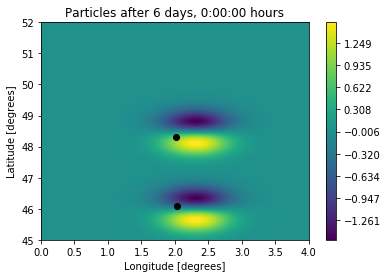

In [9]:
print(pset)
pset.show(field=fieldset.U)

Note that both the particles (the black dots) and the `U` field have moved in the plot above. Also, the `time` of the particles is now 518400 seconds, which is 6 days.

The trajectory information of the particles is stored in the `EddyParticles.nc` file. It can be quickly plotted using the `plotTrajectoriesFile` function.

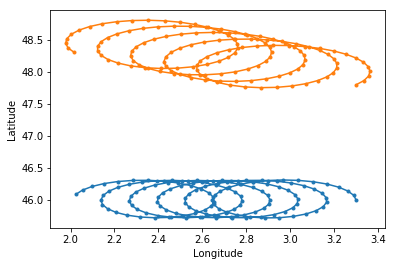

<module 'matplotlib.pyplot' from '/home/alexander/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [10]:
plotTrajectoriesFile('EddyParticles.nc')

The `plotTrajectoriesFile` function can also be used to show the trajectories as an animation, by specifying that it has to run in `movie2d_notebook` mode. If we pass this to our function above, we can watch the particles go!

In [11]:
plotTrajectoriesFile('EddyParticles.nc', mode='movie2d_notebook')

Now one of the neat features of Parcels is that the particles can be plotted as a movie *during execution*, which is great for debugging. To rerun the particles while plotting them on top of the zonal velocity field (`fieldset.U`), first reinitialise the `ParticleSet` and then re-execute. However, now rather than saving the output to a file, display a movie using the `show_movie` keyword, in this case with the zonal velocity `fieldset.U` as background

In [11]:
# THIS DOES NOT WORK IN THIS IPYTHON NOTEBOOK, BECAUSE OF THE INLINE PLOTTING.
# THE 'SHOW_MOVIE' KEYWORD WILL WORK ON MOST MACHINES, THOUGH
# pset = ParticleSet(fieldset=fieldset, size=2, pclass=JITParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])
# pset.execute(AdvectionRK4,
#              runtime=timedelta(days=6),
#              dt=timedelta(minutes=5),
#              interval=timedelta(hours=1),
#              show_movie=fieldset.U)

## Running particles in backward time

Running particles in backward time is extremely simple: just provide a `dt` < 0. 

In [12]:
pset.execute(AdvectionRK4,
             dt=-timedelta(minutes=5),      # negative timestep for backward run
             endtime=timedelta(days=0),     # the end time of the run
             interval=-timedelta(hours=1),  # negative interval for backward run
             output_file=pset.ParticleFile(name="EddyParticles_Bwd"))  # the name of the output file

Now print the particles again, and see that they (except for some round-off errors) returned to their original position

P[0](lon=3.299995, lat=45.999901, depth=0.000000, time=0.000000)
P[1](lon=3.299851, lat=47.799862, depth=0.000000, time=0.000000)


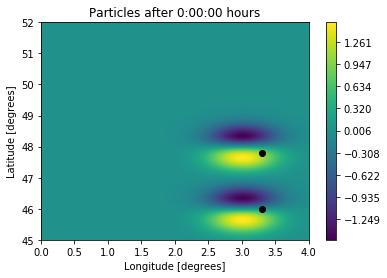

In [13]:
print(pset)
pset.show(field=fieldset.U)

## Adding a custom behaviour kernel

A key feature of Parcels is the ability to quickly create very simple kernels, and add them to the execution. Kernels are little snippets of code that are run during exection of the particles.

In this example, we'll create a simple kernel where particles obtain an extra 2 m/s westward velocity after 1 day. Of course, this is not very realistic scenario, but it nicely illustrates the power of custom kernels.

In [12]:
def WestVel(particle, fieldset, time, dt):
    if time > 86400:
        uvel = -2.
        particle.lon += uvel * dt / 1.1e5  # 1.1e5 m in 1 degree latitude

Now reset the `ParticleSet` again, and re-execute. Note that we have now changed `kernel` to be `AdvectionRK4 + k_WestVel`, where `k_WestVel` is the `WestVel` function as defined above cast into a `Kernel` object (via the `pset.Kernel` call).

In [13]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])

k_WestVel = pset.Kernel(WestVel)        # casting the WestVel function to a kernel object

pset.execute(AdvectionRK4 + k_WestVel,  # simply add kernels using the + operator
             runtime=timedelta(days=3),
             dt=timedelta(minutes=5),
             interval=timedelta(hours=1),
             output_file=pset.ParticleFile(name="EddyParticles_WestVel"))

INFO: Compiled JITParticleAdvectionRK4WestVel ==> /tmp/parcels-1000/5642ea26a201afb0df67e5e2b2d7e0bc.so


And now plot this new trajectory file

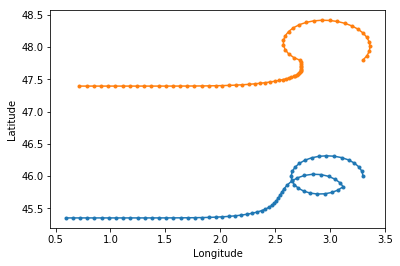

<module 'matplotlib.pyplot' from '/home/alexander/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [15]:
plotTrajectoriesFile('EddyParticles_WestVel.nc')

## Reading in data from arbritrary NetCDF files

In most cases, you will want to advect particles within pre-computed velocity fields. If these velocity fields are stored in NetCDF format, it is fairly easy to load them into the `FieldSet.from_netcdf()` function.

The `examples` directory contains a set of [GlobCurrent](http://globcurrent.ifremer.fr/products-data/products-overview) files of the region around South Africa.

First, define the names of the files containing the zonal (U) and meridional (V) velocities. You can use wildcards (`*`) and the filenames for U and V can be the same (as in this case)

In [25]:
filenames = {'U': "parcels_examples/GlobCurrent_example_data/20*.nc",
             'V': "parcels_examples/GlobCurrent_example_data/20*.nc"}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no `depth` because the GlobCurrent data is only for the surface of the ocean)

In [19]:
variables = {'U': 'eastward_eulerian_current_velocity',
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}

Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`

In [26]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

Now define a `ParticleSet`, in this case with 5 particle starting on a line between (28E, 33S) and (30E, 33S) using the `ParticleSet.from_line` constructor method

In [27]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=5,            # releasing 5 particles
                             start=(28, -33),   # releasing on a line: the start longitude and latitude
                             finish=(30, -33))  # releasing on a line: the end longitude and latitude

And finally execute the `ParticleSet` for 10 days using 4th order Runge-Kutta

In [29]:
pset.execute(AdvectionRK4,
             runtime=timedelta(days=10),
             dt=timedelta(minutes=5),
             interval=timedelta(hours=6),
             output_file=pset.ParticleFile(name="GlobCurrentParticles"))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/e95542947df78a7714bfab487ff844bf.so


Now visualise this simulation using the `plotParticles` script again. Note you can plot the particles on top of one of the velocity fields using the `tracerfile`, `tracerfield`, etc keywords.

/home/alexander/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/numpy/core/numeric.py:492: RuntimeWarning: invalid value encountered in greater
  return array(a, dtype, copy=False, order=order)


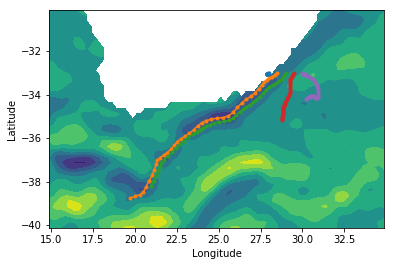

<module 'matplotlib.pyplot' from '/home/alexander/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [30]:
plotTrajectoriesFile('GlobCurrentParticles.nc',
                     tracerfile='parcels_examples/GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='eastward_eulerian_current_velocity')

## Sampling a Field with Particles

One typical use case of particle simulations is to sample a Field (such as temperature, vorticity or sea surface hight) along a particle trajectory. In Parcels, this is very easy to do, with a custom Kernel.

Let's read in another example, the flow around a Peninsula (see [Fig 2.2.3 in this document](http://archimer.ifremer.fr/doc/00157/26792/24888.pdf)), and this time also load the Pressure (`P`) field, using `extra_fields={'P': 'P'}`. Note that, because this flow does not depend on time, we need to set `allow_time_extrapolation=True` when reading in the fieldset.

In [23]:
fieldset = FieldSet.from_nemo("Peninsula_data/peninsula", extra_fields={'P': 'P'}, allow_time_extrapolation=True)

Now define a new `Particle` class that has an extra `Variable`: the pressure. We initialise this by sampling the `fieldset.P` field.

In [24]:
class SampleParticle(JITParticle):         # Define a new particle class
    p = Variable('p', initial=fieldset.P)  # Variable 'p' initialised by sampling the pressure

Now define a `ParticleSet` using the `from_line` method also used above in the GlobCurrent data. Plot the `pset` and print their pressure values `p`

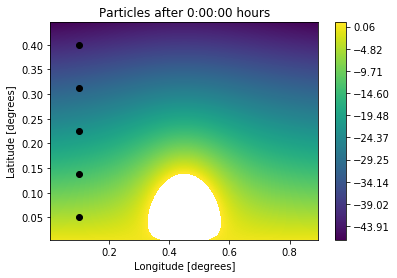

p values before execution: [-4.6339731, -13.038223, -22.007469, -31.454386, -41.185543]


In [25]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=SampleParticle, 
                             start=(0.1, 0.05), finish=(0.1, 0.4), size=5, time=0)
pset.show(field=fieldset.P, vmax=1)
print 'p values before execution:', [p.p for p in pset]

Now create a custom function that samples the `fieldset.P` field at the particle location. Cast this function to a `Kernel`.

In [26]:
def SampleP(particle, fieldset, time, dt):  # Custom function that samples fieldset.P at particle location
    particle.p = fieldset.P[time, particle.lon, particle.lat, particle.depth]

k_sample = pset.Kernel(SampleP)    # Casting the SampleP function to a kernel.

Finally, execute the `pset` with a combination of the `AdvectionRK4` and `SampleP` kernels, plot the `pset` and print their new pressure values `p`

INFO: Compiled SampleParticleAdvectionRK4SampleP ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/a1efa87239f0503ec3a36b54282be753.so


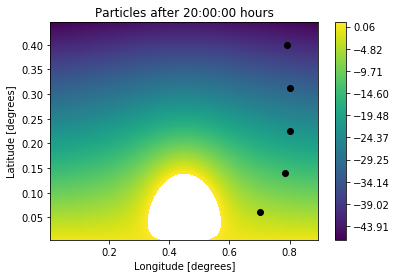

p values after execution: [-4.6339455, -13.037563, -22.007502, -31.454361, -41.18549]


In [27]:
pset.execute(AdvectionRK4 + k_sample,    # Add kernels using the + operator.
             runtime=timedelta(hours=20),
             dt=timedelta(minutes=5))
pset.show(field=fieldset.P, vmax=1)
print 'p values after execution:', [p.p for p in pset]

And see that these pressure values `p` are (within roundoff errors) the same as the pressure values before the execution of the kernels. The particles thus stay on isobars!

## Calculating distance travelled

As a second example of what custom kernels can do, we will now show how to create a kernel that logs the total distance that particles have travelled.

First, we need to create a new `Particle` class that includes three extra variables. The `distance` variable will be written to output, but the auxiliary variables `prev_lon` and `prev_lat` won't be written to output (can be controlled using the `to_write` keyword)

In [28]:
class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.

Now define a new function `TotalDistance` that calculates the sum of Euclidean distances between the old and new locations in each RK4 step

In [29]:
def TotalDistance(particle, fieldset, time, dt):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

We will run this on a `ParticleSet` containing the two particles within the idealised moving eddies fieldset from above. Note that `pclass=DistParticle` in this case

In [30]:
fieldset = FieldSet.from_nemo("MovingEddies_data/moving_eddies")
pset = ParticleSet.from_list(fieldset=fieldset, pclass=DistParticle, lon=[3.3, 3.3], lat=[46.0, 47.8])

Again define a new kernel to include the function written above and execute the `ParticleSet`.

In [31]:
k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.

pset.execute(AdvectionRK4 + k_dist,  # Add kernels using the + operator.
             runtime=timedelta(days=6),
             dt=timedelta(minutes=5),
             interval=timedelta(hours=1),
             output_file=pset.ParticleFile(name="EddyParticles_Dist"))

INFO: Compiled DistParticleAdvectionRK4TotalDistance ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gn/T/parcels-501/ff72d45a3f6df0b368c6f9068a044b79.so


And finally print the distance that each particle has travelled (note that this is also stored in the `EddyParticles_Dist.nc` file)

In [32]:
print [p.distance for p in pset]

[952.56293, 990.17273]
